# Computer, code thyself #
#### Ann Arbor Scientific and Technical Computing, February 25th 2021
#### Presented by David Perner
<img src="img/drawing-hands.jpg!Large.jpg" style="width:600px"></img>

## So what is genetic programming?
Genetic programming is using the ideas of Darwinian evolution to generate code (almost) automatically. In general, this requires some basic operators
1. Generation of a random initial population of code to test out
2. A way to evaluate how well (how fit) each of these bits of code are for what we want them to do
3. A way to go through the best performers and use them to create new bits of code for the next generation
4. A way to add in some mutations so that solutions can become a bit more diverse over time.
5. A way to iterate through steps 2-4 repeatedly until meet some threshold, either convergence, sufficient performance, or number of iterations

Genetic algorithms have been used in a variety of applications, such as these (somewhat odd, but apparently very effective) antennas
<img src="img/antennas.jpg"></img>

## So how do we get computers to write code?
Different languages have different capabilities in this regard, however languages like `Lisp` or (of course, since I use it for everything) `Julia` have the ability to manipulate and evaluate expressions directly. This is generally referred to as meta programming, or programs that write programs. So what does a `Julia` expression look like?

In [31]:
a = Meta.parse("x^2+x-1")

:((x ^ 2 + x) - 1)

In [32]:
Meta.dump(a)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol -
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol ^
            2: Symbol x
            3: Int64 2
        3: Symbol x
    3: Int64 1


In [2]:
using StatsBase
using Plots

In [3]:
function eval_at_x(expr, x)
    eval(
        quote
            local x = $(x)
            $expr
        end
    )
end

eval_at_x (generic function with 1 method)

In [4]:
eval_at_x(:(sin(x)), π/2)

1.0

In [5]:
#arity1s = [sin, cos, -]
arity2s = [+, -, *, /]
terminals = [:x, 1.0:10.0];

In [6]:
function sample_terminal(t)
    t_temp = sample(t)
    isa(t_temp, Symbol) ? t_temp : t_temp[sample(1:length(t_temp))]
end

sample_terminal (generic function with 1 method)

In [7]:
function gen_rand_expr(a2, t; dmax=5, d=1)
    op = sample(a2)
    t1 = sample_terminal(t)
    if d==1
        if rand()>0.5 #switch the branching directions for diversity 
            Expr(:call, op, t1, gen_rand_expr(a2, t, d=d+1))
        else
            Expr(:call, op, gen_rand_expr(a2, t, d=d+1), t1)
        end
    elseif d==dmax
        t2=sample_terminal(t)
        Expr(:call, op, t1, t2) #terminate the expression at maximum depth
    else
        if rand()>0.5 #switch the branching directions for diversity 
            Expr(:call, op, t1, gen_rand_expr(a2, t, d=d+1)) 
        else
            Expr(:call, op, gen_rand_expr(a2, t, d=d+1), t1) 
        end
    end 
end

gen_rand_expr (generic function with 1 method)

In [8]:
test_expr = gen_rand_expr(arity2s, terminals)

:((*)(x, (*)((*)((*)(3.0, (+)(x, 1.0)), 5.0), 3.0)))

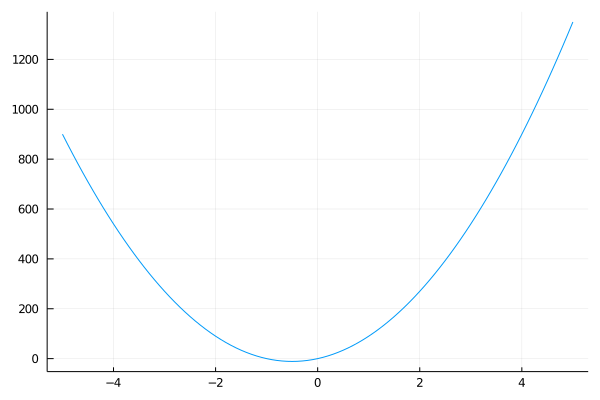

In [9]:
plot(x->eval_at_x(test_expr,x), range(-5,5,step=0.1), legend=nothing)

In [10]:
test_expr2 = gen_rand_expr(arity2s, terminals)

:((/)((*)((-)(9.0, (+)(10.0, (*)(x, x))), 3.0), 5.0))

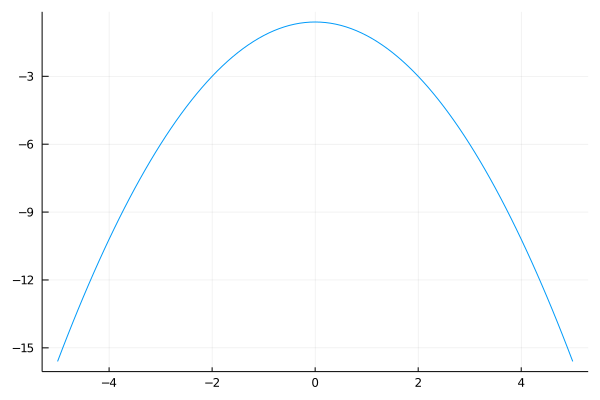

In [11]:
plot(x->eval_at_x(test_expr2,x), range(-5,5,step=0.1), legend=nothing)

## Now for the GA machinery

In [12]:
function mutate_expr!(expr, a2, t, ϕ)
    sub_expr=expr
    while true
        if rand() < ϕ
            if rand()>0.5 #flip either the function or the terminator
                sub_expr.args[1] = sample(a2)
            else
                if isa(sub_expr.args[2], Expr) && !isa(sub_expr.args[3], Expr)
                   sub_expr.args[3] = sample_terminal(t) 
                else
                   sub_expr.args[2] = sample_terminal(t) 
                end
            end
        end
        expr_idx = findfirst(x->isa(x,Expr), sub_expr.args)
        if !isnothing(expr_idx)
            sub_expr = sub_expr.args[expr_idx]
        else #final subexpression 
            if rand() < ϕ
                if rand()>0.5
                    sub_expr.args[1] = sample(a2) 
                else
                    sub_expr.args[sample(2:3)] = sample_terminal(t)
                end
            end
            break
        end
    end
end

mutate_expr! (generic function with 1 method)

In [13]:
mutate_expr!(test_expr, arity2s, terminals, 1)

In [14]:
test_expr

:((*)(7.0, (-)((*)((*)(x, (-)(x, 1.0)), 5.0), 3.0)))

In [24]:
function crossover(expr1, expr2, ψ)
    new_expr = deepcopy(expr1)
    sub_expr1 = new_expr
    sub_expr2 = deepcopy(expr2)
    
    while true
        sub1_idxs = findall(x-> isa(x, Expr), sub_expr1.args)
        sub2_idxs = findall(x-> isa(x, Expr), sub_expr2.args)
        if isempty(sub1_idxs) && isempty(sub2_idxs) #end of tree, swap final expression
            sub_expr1 = copy(sub_expr2)
            return new_expr
        elseif rand()>ψ 
            if isempty(sub2_idxs)
                sub_expr1.args[sample(sub1_idxs)] = copy(sub_expr2)
            elseif isempty(sub1_idxs)
                sub_expr1=copy(sub_expr2)
            else
                sub_expr1.args[sample(sub1_idxs)] = copy(sub_expr2.args[sample(sub2_idxs)])
            end
            return new_expr
        else #continue walking tree
            sub_expr1=sub_expr1.args[sample(sub1_idxs)] 
            sub_expr2=sub_expr2.args[sample(sub2_idxs)]

        end
    end
end

crossover (generic function with 1 method)

In [16]:
crossover(test_expr, test_expr2, 0.5)

:((*)(7.0, (*)((-)(9.0, (+)(10.0, (*)(x, x))), 3.0)))

In [17]:
function fitness(expr, truth, xrange)
    y_expr = map(x->eval_at_x(expr, x), xrange)
    y_truth = truth.(xrange)
    rmsd(y_truth, y_expr)
end

fitness (generic function with 1 method)

In [18]:
fitness(test_expr, cos, range(-2π,2π,length=1000))

616.7997660274536

In [19]:
function selection(exprs, perfs) #performance and exprs should be pre-sorted
    cum_perfs=cumsum(perfs)/sum(perfs)
    cutoff=rand()
    expr_idx = findlast(x->x<cutoff, cum_perfs)
    if isnothing(expr_idx)
       expr_idx = 1
    end
    expr1 = exprs[expr_idx]
end

selection (generic function with 1 method)

In [25]:
function run_GA(pop_size, a2, t, truth, xrange; ϕ=0.15, ψ=0.25, final_Δ=1e-6, max_iter=100)
    exprs = Array{Expr,1}(undef, pop_size)
    best_expr_hist = []
    best_perf_hist = []
    ## Generate initial population
    Threads.@threads for expr_idx=1:pop_size
        exprs[expr_idx] = gen_rand_expr(a2,t,dmax=6)
    end
    
    best_Δ=Inf
    num_iter=1
    
    #Iterate using genetic operators
    while true
        #Find the fitness/performance of the expressions
        perfs = map(x->fitness(x, truth, xrange), exprs)
        sort_idx = sortperm(abs.(perfs.-1))
        best_Δ=abs(perfs[sort_idx[1]]-1)
        println("Generation " *string(num_iter)* ", best RMS error is " *string(best_Δ))
        perfs = 1 ./ perfs[sort_idx] #inverse since we're trying to minimize RMS, although it may blow up
        exprs = exprs[sort_idx]
        
        #Use fitness to generate the next generation
        exprs_next = Array{Expr,1}(undef, pop_size)
        exprs_next[1]=deepcopy(exprs[1]) #retain best solution
        Threads.@threads for expr_idx=2:pop_size
            expr1 = selection(exprs, perfs)
            expr2 = selection(exprs, perfs)
            exprs_next[expr_idx] = crossover(expr1, expr2, ψ) 
        end
        
        #Sprinkle in some mutations
        map(x->mutate_expr!(x, a2, t, ϕ), exprs_next)
        
        push!(best_expr_hist, deepcopy(exprs[1]))
        push!(best_perf_hist, perfs[1])
        
        if best_Δ< final_Δ || num_iter>=max_iter
            return (best_expr_hist, best_perf_hist)
        else            
            exprs = exprs_next
            num_iter+=1
        end
    end 
end

run_GA (generic function with 1 method)

In [26]:
xrange = range(-10, 10, length=100)
truth = x->(x+1)*(x-5)*(x+3.5)
(best_expr_hist, best_perf_hist) = run_GA(50, arity2s, terminals, truth, xrange, max_iter=100);

Generation 1, best RMS error is 190.84770876620826
Generation 2, best RMS error is 190.84770876620826
Generation 3, best RMS error is 212.51306354413055
Generation 4, best RMS error is 167.2162917812557
Generation 5, best RMS error is 165.95655648843464
Generation 6, best RMS error is 166.6380385130298
Generation 7, best RMS error is 165.95655648843464
Generation 8, best RMS error is 165.95655648843464
Generation 9, best RMS error is 167.2162917812557
Generation 10, best RMS error is 166.40521265029153
Generation 11, best RMS error is 166.6380385130298
Generation 12, best RMS error is 162.23658254274483
Generation 13, best RMS error is 161.75134393337828
Generation 14, best RMS error is 161.75134393337828
Generation 15, best RMS error is 162.23658254274483
Generation 16, best RMS error is 158.54708471064748
Generation 17, best RMS error is 158.54708471064748
Generation 18, best RMS error is 160.24972672783133
Generation 19, best RMS error is 157.69857771773772
Generation 20, best RMS e

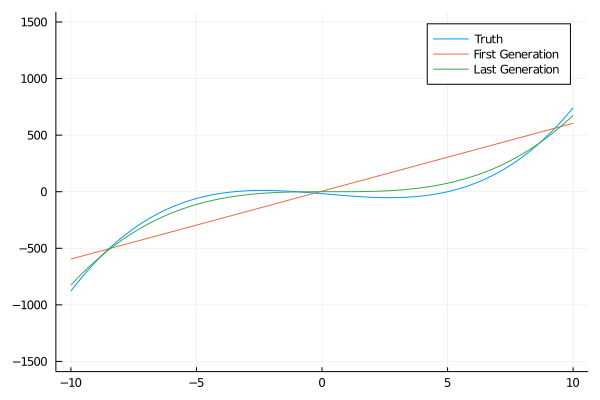

In [27]:
se_plot = plot(truth, xrange, label="Truth", ylim=[-1500,1500])
plot!(se_plot, x->eval_at_x(best_expr_hist[1],x), xrange, label="First Generation")
plot!(se_plot, x->eval_at_x(best_expr_hist[end],x), xrange, label="Last Generation")

In [30]:
best_expr_hist[end]

:((/)((*)(x, (*)((-)((*)(x, x), x), 3.0)), 4.0))

┌ Info: Saved animation to 
│   fn = /Users/crashburnrepeat/AASTC/February 2021/img/gp_hist.gif
└ @ Plots /Users/crashburnrepeat/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/Users/crashburnrepeat/AASTC/February 2021/img/gp_hist.gif")
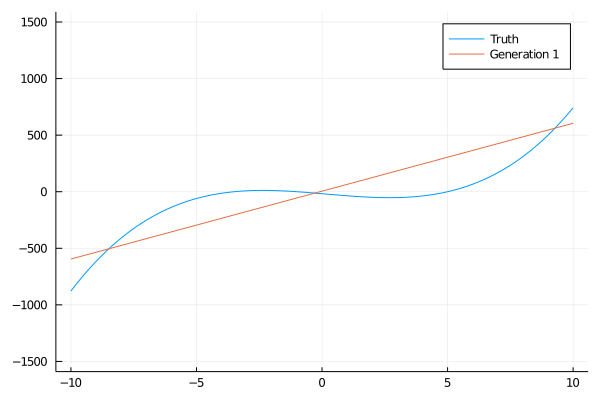

In [29]:
anim = @animate for i in range(1, length=length(best_expr_hist))
    se_plot = plot(truth, xrange, label="Truth", ylim=[-1500,1500])
    plot!(se_plot, x->eval_at_x(best_expr_hist[i],x), xrange, label="Generation "*string(i))
end
gif(anim, "img/gp_hist.gif", fps=60)

## Some final thoughts
- The power of this approach can be a lot more powerful than what I'm showing, and I suspect there are bugs I haven't yet had the time to find. 
- There are some interesting parallels between this approach and neural networks. ANNs take a bunch of subunits (neurons) and tweek the weightings between them (and sometimes the architecture itself) in order to mimic a wide variety of complex behaviors. Genetic programming is perhaps more general, but at the same time the much wider space the genetic algorithm has to explore makes it much harder to find good solutions.
- Hopefully though, when compare to ANNs, the results of GP are easier to decode, since it's generating code instead of a set of arbitrary weightings. Still, there's no guarantee that this code would be "human readable"